In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
import matplotlib.dates as mdates
from jupyterthemes import jtplot
jtplot.style()
#https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Define the tickers. We would like to see Apple, Tesla and the S&P500 index.
tickers = ['AAPL', 'TSLA', 'SPY','IBM','KO']
# define starting date from '01/01/2018' until '30/05/2020'.
start_date = '01/01/2018'
end_date = '30/05/2020'
# User pandas_reader.data.DataReader to load the desired data.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
close = panel_data['Close']
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill').dropna()

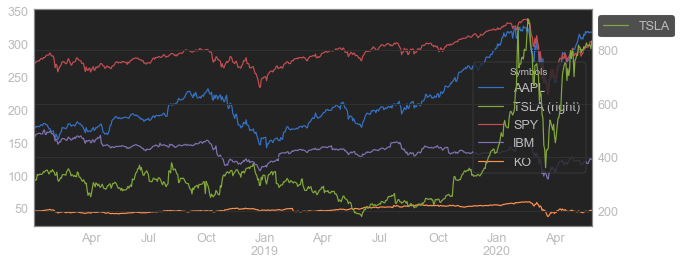

In [3]:
close.plot(figsize=(10,4),secondary_y=['TSLA'])
plt.legend(bbox_to_anchor=(1,1));

In [5]:
# close['AAPL_pct_change'] = close['AAPL'].pct_change()
# close['Returns_1'] = (close.loc['2018-02-04':,'AAPL_pct_change']).cumsum()
# close['Returns_2'] = (close.loc['2018-09-11':,'AAPL_pct_change']).cumsum()
# close['Returns_3'] = (close.loc['2019-02-07':,'AAPL_pct_change']).cumsum()
# close['Returns_4'] = (close.loc['2019-09-10':,'AAPL_pct_change']).cumsum()
# close.fillna(0,inplace=True)
# tot_b = first_buy+second_buy+third_buy+fourth_buy
# close['Cum_in'] = first_buy*(1+close['Returns_1'])+second_buy*(1+close['Returns_2'])+third_buy*(1+close['Returns_3'])+fourth_buy*(1+close['Returns_4'])
# close['Cum_ret_%'] = (close['Cum_in']-tot_b)/tot_b

In [6]:
close.tail()

Symbols,AAPL,TSLA,SPY,IBM,KO,AAPL_pct_change,Returns_1,Returns_2,Returns_3,Returns_4
2020-05-25,318.890015,816.880005,295.440002,118.389999,45.029999,0.000000,0.825609,0.501417,0.693678,0.468856
2020-05-26,316.730011,818.869995,299.079987,121.760002,46.090000,-0.006774,0.818836,0.494644,0.686905,0.462083
2020-05-27,318.109985,820.229980,303.529999,125.540001,46.730000,0.004357,0.823193,0.499001,0.691262,0.466440
2020-05-28,318.250000,805.809998,302.970001,124.529999,47.090000,0.000440,0.823633,0.499441,0.691702,0.466880
2020-05-29,317.940002,835.000000,304.320007,124.900002,46.680000,-0.000974,0.822659,0.498467,0.690728,0.465906


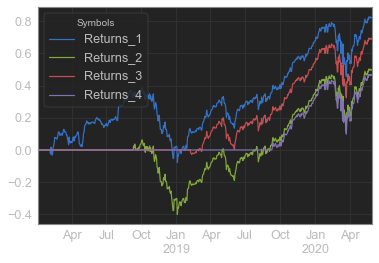

In [7]:
close.filter(like='Returns').plot();

In [8]:
close.index.max()

Timestamp('2020-05-29 00:00:00', freq='B')

In [9]:
close.loc[close.index.max():,]

Symbols,AAPL,TSLA,SPY,IBM,KO,AAPL_pct_change,Returns_1,Returns_2,Returns_3,Returns_4
2020-05-29,317.940002,835.0,304.320007,124.900002,46.68,-0.000974,0.822659,0.498467,0.690728,0.465906


In [10]:
def tether(x):
    return np.round((x.max() + x.min())/2,0)

close = panel_data['Close'].copy()
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')
close = close.reindex(all_weekdays)
close = close.fillna(method='ffill').dropna()

In [11]:
for name in tickers:
    close[name+'_SMA14'] = close[name].rolling(window=14,min_periods=1).mean()
    close[name+'_THT'] = close[name].rolling(window=40).apply(tether, raw=True)
    close['SMA14>Tether_'+name] = close.apply(lambda x: 1 if x[name+'_SMA14']>=x[name+'_THT'] else 0, 1)
    close[name+'_Return'] = close[name].pct_change()
    close[name+'_TTH_diff'] = close['SMA14>Tether_'+name].diff()

In [12]:
close.head(1)

Symbols,AAPL,TSLA,SPY,IBM,KO,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,...,IBM_SMA14,IBM_THT,SMA14>Tether_IBM,IBM_Return,IBM_TTH_diff,KO_SMA14,KO_THT,SMA14>Tether_KO,KO_Return,KO_TTH_diff
2018-01-02,172.259995,320.529999,268.769989,154.25,45.540001,172.259995,NaN,0,NaN,NaN,...,154.25,NaN,0,NaN,NaN,45.540001,NaN,0,NaN,NaN


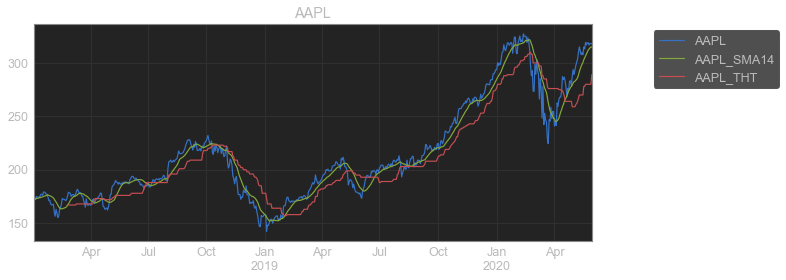

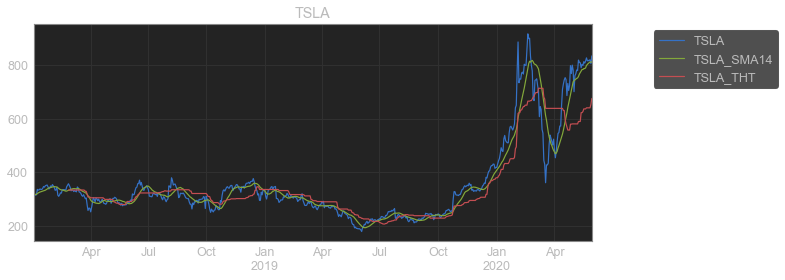

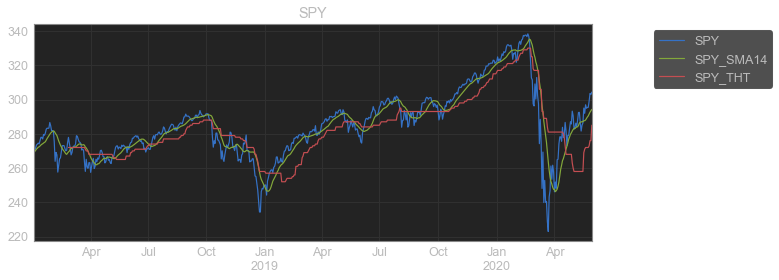

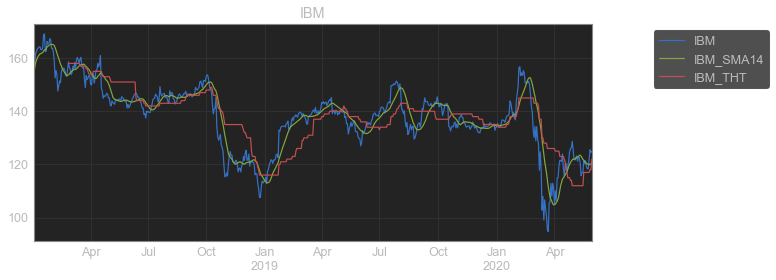

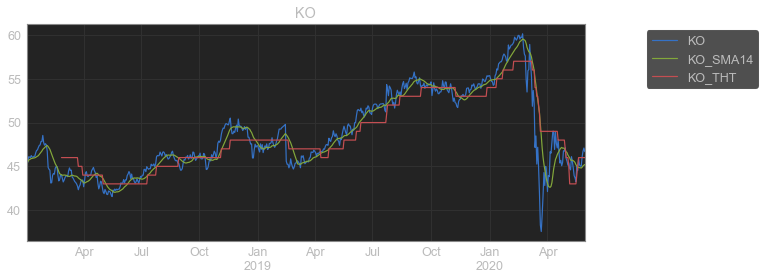

In [13]:
for tick in tickers:
    close[[tick,tick+'_SMA14',tick+'_THT']].plot(title=tick, figsize=(10,4),legend=False)
    plt.legend(bbox_to_anchor=(1.1,1));

In [48]:
#sell when SMA14 < tether
#buy when SMA > tether
close.filter(like='AAPL').copy()

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff
2018-01-02,172.259995,172.259995,NaN,0,NaN,NaN
2018-01-03,172.229996,172.244995,NaN,0,-0.000174,0.0
2018-01-04,173.029999,172.506663,NaN,0,0.004645,0.0
2018-01-05,175.000000,173.129997,NaN,0,0.011385,0.0
2018-01-08,174.350006,173.373999,NaN,0,-0.003714,0.0
...,...,...,...,...,...,...
2020-05-25,318.890015,311.984290,280.0,1,0.000000,0.0
2020-05-26,316.730011,313.134290,280.0,1,-0.006774,0.0
2020-05-27,318.109985,314.160719,280.0,1,0.004357,0.0
2020-05-28,318.250000,314.740718,280.0,1,0.000440,0.0


In [49]:
tickers=['AAPL']
for tick in tickers:
    df_tick = close.filter(like=tick).copy()
    buy_order = df_tick[tick+'_TTH_diff']>0
    sell_order = df_tick[tick+'_TTH_diff']<0
    df_tick['tot_return'] = df_tick[tick+'_Return'].cumsum()
    for i in range(len(df_tick[buy_order])):
        df_tick['Returns_'+str(i)] = (df_tick.loc[df_tick[buy_order].index[i]:,tick+'_Return']).cumsum()

# aapl_s[buy_order|sell_order]

In [50]:
df_tick.head()

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6
2018-01-02,172.259995,172.259995,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,172.229996,172.244995,NaN,0,-0.000174,0.0,-0.000174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,173.029999,172.506663,NaN,0,0.004645,0.0,0.004471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,175.000000,173.129997,NaN,0,0.011385,0.0,0.015856,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,174.350006,173.373999,NaN,0,-0.003714,0.0,0.012142,NaN,NaN,NaN,NaN,NaN,NaN,NaN


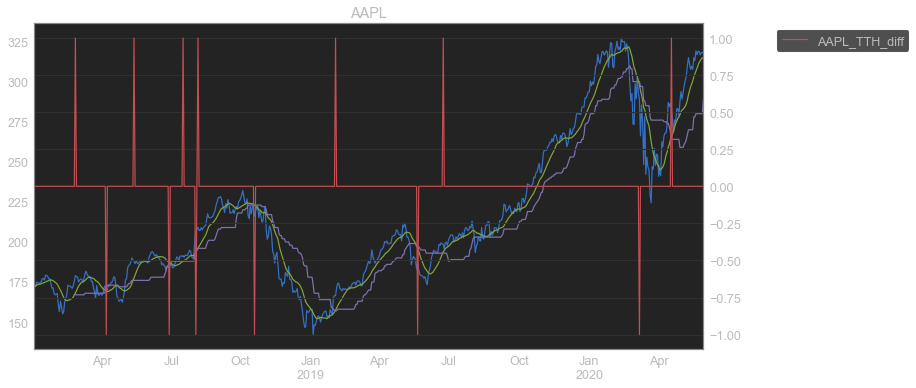

In [51]:
df_tick[[tick,tick+'_SMA14',tick+'_TTH_diff',tick+'_THT']].plot(title=tick, figsize=(12,6),legend=False, secondary_y=[tick+'_TTH_diff'])
plt.legend(bbox_to_anchor=(1.1,1));

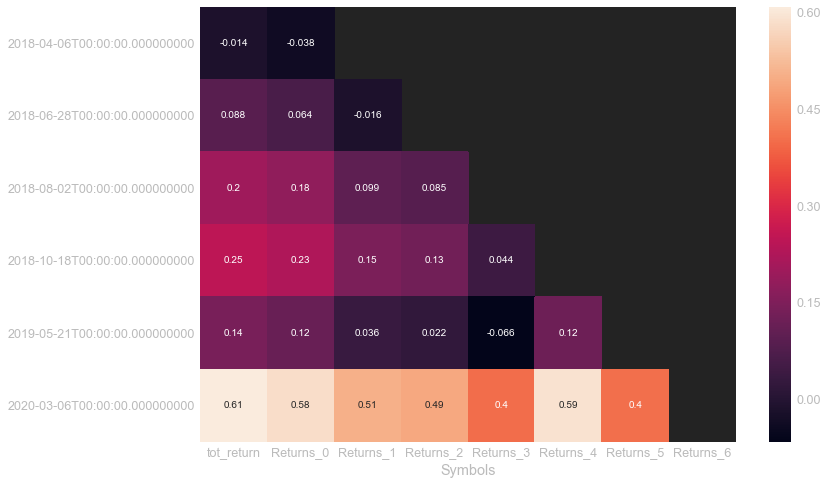

In [52]:
plt.figure(figsize=(12,8))
sns.heatmap(df_tick[sell_order].drop([tick,'SMA14>Tether_'+tick,tick+'_TTH_diff',tick+'_SMA14',tick+'_THT',tick+'_Return'],1),annot=True)

In [53]:
df_tick[buy_order]

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6
2018-02-26,178.970001,168.090000,167.0,1,0.019772,1.0,0.043834,0.019772,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-14,188.149994,177.656429,176.0,1,-0.002333,1.0,0.101498,0.077436,-0.002333,NaN,NaN,NaN,NaN,NaN
2018-07-17,191.449997,188.037857,188.0,1,0.002829,1.0,0.120495,0.096432,0.016663,0.002829,NaN,NaN,NaN,NaN
2018-08-06,209.070007,196.035001,196.0,1,0.005193,1.0,0.210925,0.186863,0.107093,0.093259,0.005193,NaN,NaN,NaN
2019-02-01,166.520004,157.455716,157.0,1,0.000481,1.0,0.017206,-0.006856,-0.086625,-0.100460,-0.188526,0.000481,NaN,NaN
2019-06-24,198.580002,193.814999,193.0,1,-0.001006,1.0,0.204311,0.180249,0.100479,0.086645,-0.001422,0.187585,-0.001006,NaN
2020-04-17,282.799988,265.693568,264.0,1,-0.013569,1.0,0.632738,0.608675,0.528906,0.515071,0.427005,0.616012,0.427421,-0.013569


In [54]:
df_tick[sell_order]

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6
2018-04-06,168.380005,169.379287,172.0,0,-0.025579,-1.0,-0.013703,-0.037765,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-28,185.500000,187.244286,188.0,0,0.007276,-1.0,0.088250,0.064188,-0.015582,NaN,NaN,NaN,NaN,NaN
2018-08-02,207.389999,193.556429,195.0,0,0.029231,-1.0,0.202839,0.178777,0.099008,0.085173,NaN,NaN,NaN,NaN
2018-10-18,216.020004,222.940714,223.0,0,-0.023374,-1.0,0.249302,0.225240,0.145471,0.131636,0.043570,NaN,NaN,NaN
2019-05-21,186.600006,196.222142,197.0,0,0.019171,-1.0,0.139719,0.115657,0.035888,0.022053,-0.066013,0.122994,NaN,NaN
2020-03-06,289.029999,298.184280,300.0,0,-0.013280,-1.0,0.608954,0.584892,0.505123,0.491288,0.403222,0.592229,0.403638,NaN


In [55]:
investment = 1000
returns=[]
sells_return=[]
for col in df_tick[sell_order].filter(like='Returns').columns:
    try:
        sell_return = np.round(df_tick[sell_order].filter(like='Returns')[col].dropna()[0],3)
        sells_return.append(sell_return)
        investment = np.round(investment*(1+sell_return),2)
        returns.append(investment)
        print(col,sell_return,investment)
    except:
        print(col,0)
        #returns.append(investment)
print(investment/1000-1)

Returns_0 -0.038 962.0
Returns_1 -0.016 946.61
Returns_2 0.085 1027.07
Returns_3 0.044 1072.26
Returns_4 0.123 1204.15
Returns_5 0.404 1690.63
Returns_6 0
0.6906300000000001


In [56]:
returns_df = pd.DataFrame(sells_return, index= df_tick[sell_order].index, columns=['Sells_Return'])

In [57]:
returns_df['Tot_Return'] = returns_df['Sells_Return'].cumsum()

Text(0.5, 1.0, 'Trading returns')

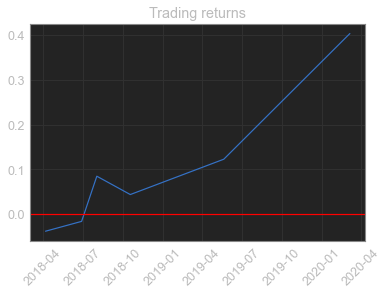

In [58]:
plt.plot(df_tick[sell_order].index,sells_return)
plt.xticks(rotation=45)
plt.axhline(0,color='red')
plt.title('Trading returns')

Text(0.5, 1.0, 'Trading investment returns')

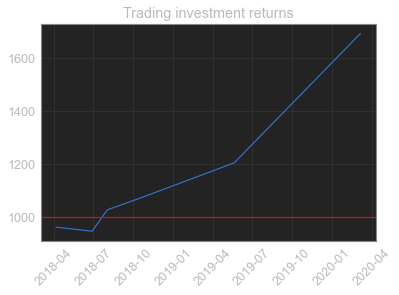

In [59]:
plt.plot(df_tick[sell_order].index,returns)
plt.xticks(rotation=45)
plt.axhline(1000,color='red')
plt.title('Trading investment returns')

In [60]:
df_tick.tail()

Symbols,AAPL,AAPL_SMA14,AAPL_THT,SMA14>Tether_AAPL,AAPL_Return,AAPL_TTH_diff,tot_return,Returns_0,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6
2020-05-25,318.890015,311.984290,280.0,1,0.000000,0.0,0.756743,0.732681,0.652912,0.639077,0.551011,0.740018,0.551427,0.110437
2020-05-26,316.730011,313.134290,280.0,1,-0.006774,0.0,0.749970,0.725908,0.646138,0.632304,0.544238,0.733244,0.544653,0.103664
2020-05-27,318.109985,314.160719,280.0,1,0.004357,0.0,0.754327,0.730265,0.650495,0.636661,0.548595,0.737601,0.549010,0.108021
2020-05-28,318.250000,314.740718,280.0,1,0.000440,0.0,0.754767,0.730705,0.650936,0.637101,0.549035,0.738042,0.549450,0.108461
2020-05-29,317.940002,314.950003,289.0,1,-0.000974,0.0,0.753793,0.729731,0.649961,0.636127,0.548061,0.737067,0.548476,0.107487


Text(0.5, 1.0, 'Trading returns')

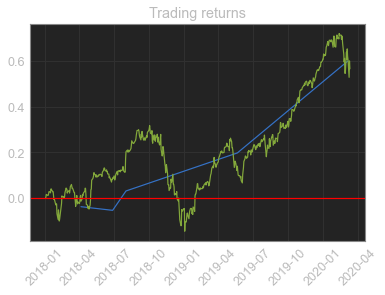

In [61]:
plt.plot(returns_df.index,returns_df['Tot_Return'])
plt.plot(df_tick[df_tick.index<'2020-03-12'].index,df_tick[df_tick.index<'2020-03-12'].tot_return)
plt.xticks(rotation=45)
plt.axhline(0,color='red')
plt.title('Trading returns')